**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Evaluation metric**
macro f1 score

> **Load the `clean data` preprocessed in `Assignment 1`, then handle it to be used with `RNNs`**

### Global Variables :

In [68]:
RANDOM_STATE = 42

### Import Libraries

In [53]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# NLTK and spacy for text
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk
# import spacy
# nlp = spacy.load('en_core_web_lg')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Set pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)


[nltk_data] Downloading package stopwords to /home/israa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/israa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/israa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/israa/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [70]:
np.random.seed(RANDOM_STATE)

### Load Dataset

In [54]:
df = pd.read_csv("/home/israa/Desktop/NLP_Projects/Assignment_1/Hate Speech.tsv", sep="\t", index_col='id')
df.head(30)

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦


Insights from the data to determine the preprossing needed:

- mentions like @user
- `#` remove
- punctiuations 
- non words like ±!!! ððð (non ascii)
- things like [2/2]
- remove numbers 


In the case of # we have 2 options :
- remove the whole # with the word after it 
- remove the # sign only 

In our case Because hashtags often hold valuable meaning (e.g., #gold, #forex, #michigan) so it can make difference.



In [63]:
X = df.drop(columns=['label'])
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [74]:
# train_compined = pd.concat([x_train, y_train], axis=1)
# train_compined = train_compined.reset_index(drop=True)

In [75]:
# # Apply SMOTE only on training data
# sm = SMOTE(random_state=42)
# # X_train_res, y_train_res = sm.fit_resample(x_train, y_train)

In [79]:
train_combined = pd.concat([x_train, y_train], axis=1)
test_combined = pd.concat([x_test, y_test], axis=1)

In [80]:
train_combined.drop_duplicates(inplace=True)
test_combined.drop_duplicates(inplace=True)
X_train = train_combined.drop('label', axis=1)
y_train = train_combined['label']
X_test = test_combined.drop('label', axis=1)
y_test = test_combined['label']

In [81]:
train_combined.isnull().sum()

tweet    0
label    0
dtype: int64

In [82]:
train_combined.value_counts('label')

label
0    21834
1     1600
Name: count, dtype: int64

Data is unbalanced

In [83]:
print("Unique label in corpus:", train_combined['label'].nunique())
print("Unique tweet in corpus:", train_combined['tweet'].nunique())

Unique label in corpus: 2
Unique tweet in corpus: 23433


In [84]:
train_combined.duplicated().sum()

0

In [85]:
train_combined.columns

Index(['tweet', 'label'], dtype='object')

<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

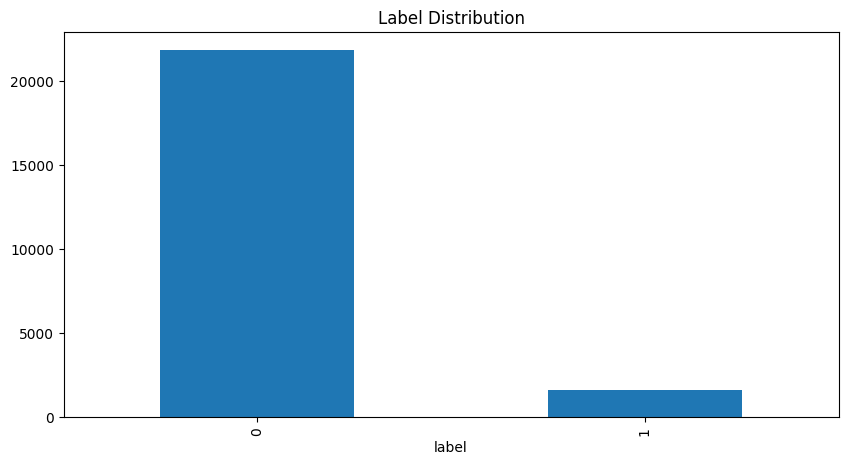

In [86]:
train_combined['label'].value_counts().plot(kind='bar', title='Label Distribution', figsize=(10, 5))
# df_cleaned['label'].value_counts(normalize=True).plot(kind='bar', title='Label Distribution (Normalized)', figsize=(10, 5))

### Preprocessing

In [87]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 fix_encoding=True, 
                 remove_hashtags=True, 
                 remove_mentions=True, 
                 remove_punctuation=True, 
                 lowercase=True, 
                 remove_stopwords=True, 
                 remove_urls=True, 
                 lemmatize=False, 
                 stem=True,
                 replace_slang=True,
                 remove_numbers=True,
                 remove_stock_symbols=True):
        
        self.fix_encoding = fix_encoding
        self.remove_hashtags = remove_hashtags
        self.remove_mentions = remove_mentions
        self.remove_punctuation = remove_punctuation
        self.lowercase = lowercase
        self.remove_stopwords = remove_stopwords
        self.remove_urls = remove_urls
        self.lemmatize = lemmatize
        self.stem = stem
        self.replace_slang = replace_slang
        self.remove_numbers = remove_numbers
        self.remove_stock_symbols = remove_stock_symbols
        
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        if not isinstance(text, str):
            return ''
        
        if self.fix_encoding:
            text = self._fix_encoding(text)
        if self.lowercase:
            text = text.lower()
        if self.replace_slang:
            text = self._replace_slang(text)
        if self.remove_urls:
            text = self._remove_urls(text)
        if self.remove_hashtags:
            text = self._remove_hashtags(text)
        if self.remove_mentions:
            text = self._remove_mentions(text)
        if self.remove_punctuation:
            text = self._remove_punctuation(text)
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)
        if self.remove_stock_symbols:
            text = re.sub(r'\$\w+', '', text)

        words = text.split()
        if self.remove_stopwords:
            words = [w for w in words if w not in self.stop_words]
        if self.lemmatize:
            words = [self.lemmatizer.lemmatize(w) for w in words]
        if self.stem:
            words = [self.stemmer.stem(w) for w in words]

        return ' '.join(words)

    def _fix_encoding(self, text):
        return text.encode("ascii", "ignore").decode()

    def _replace_slang(self, text):
        slang_dict = {
            r'\bur\b': 'your',
            r'\bu\b': 'you',
            r'\bgr8\b': 'great',
            r'\b4u\b': 'for you',
            # r'\blol\b': 'laughing out loud'
        }
        for slang, replacement in slang_dict.items():
            text = re.sub(slang, replacement, text)
        return text
    

    def _remove_urls(self, text):
        return re.sub(r'https?://\S+|www\.\S+', '', text)

    def _remove_hashtags(self, text):
        return re.sub(r'#', '', text)
    
    def _remove_mentions(self, text):
        return re.sub(r'@\w+', '', text)
    
    def _remove_punctuation(self, text):
        return re.sub(r'[^\w\s]', '', text)


In [88]:
train_data_copied = train_combined.copy()

In [89]:
preprocessor = TextPreprocessor()

train_data_copied['tweet'] = preprocessor.fit_transform(train_data_copied['tweet'])

train_data_copied['tweet'].head(10)

id
9414                                    would like wish father day famili dad fathersday
17664                                                 alway enjoy life grate mondaymotiv
438      kayak sup snorkel swimwhatev pleasur well put togeth alohabeachbu hawaii explor
21957                   think alexjon say draintheswamp populationcontrol good video got
16373                                   well guess cant join server mcpe mcpe mcpc weird
12586                                                          trump associ classi bunch
5045                                                      play intwin classic rock attic
448                                      lewi remain perfect ranger announc gonna stroke
2339                cool treat hot hot day widn frozenyogu tuesday dclife summer gogreen
636                                                            actual order kyli lip kit
Name: tweet, dtype: object

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, num_words=10000, max_len=100, oov_token="<OOV>"):
        self.num_words = num_words
        self.max_len = max_len
        self.oov_token = oov_token
        self.tokenizer = None

    def fit(self, X, y=None):
        self.tokenizer = Tokenizer(num_words=self.num_words, oov_token=self.oov_token)
        self.tokenizer.fit_on_texts(X)
        return self

    def transform(self, X):
        sequences = self.tokenizer.texts_to_sequences(X)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post')
        return padded

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)


In [36]:
# 1. Create tokenizer for top 10,000 words
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")

# 2. Fit on cleaned text (make sure df['text'] is cleaned)
tokenizer.fit_on_texts(df_cleaned['tweet'])

# 3. Convert text to sequences of word indices
sequences = tokenizer.texts_to_sequences(df_cleaned['tweet'])

# Optional: print first 2
print(sequences[:2])

[[18, 5222, 2479, 1799, 127, 5222, 189], [6, 4510, 1941, 25, 98, 424, 29, 860, 6208, 3572, 6209, 1, 7861]]


In [39]:
print([tokenizer.index_word[i] for i in [18, 5222, 2479, 1799, 127, 5222, 189]]) # example of word indices
print([tokenizer.index_word[i] for i in [6, 4510, 1941, 25, 98, 424, 29, 860, 6208, 3572, 6209, 1, 7861]]) # example of word indices

['father', 'dysfunct', 'selfish', 'drag', 'kid', 'dysfunct', 'run']
['thank', 'lyft', 'credit', 'cant', 'use', 'caus', 'dont', 'offer', 'wheelchair', 'van', 'pdx', '<OOV>', 'getthank']


### Modelling

#### Evaluation

### Enhancement

### Results & Conclusion

#### Done!